# Dự án Dịch Máy: Seq2Seq với Attention (EN → FR)

## Cài đặt và tải dữ liệu

In [1]:
!pip install spacy==3.8.2 torchtext==0.18.0 sacrebleu
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
import random
!python -m spacy download en_core_web_sm

import spacy
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

# Tải dữ liệu Multi30K
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.fr.gz

!gunzip -f *.gz

def load_lines(file):
    with open(file, encoding='utf-8') as f:
        return [line.strip() for line in f]

train_en = load_lines("train.en")
train_fr = load_lines("train.fr")
val_en   = load_lines("val.en")
val_fr   = load_lines("val.fr")
test_en  = load_lines("test_2016_flickr.en")
test_fr  = load_lines("test_2016_flickr.fr")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 58.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.11
    Uninstalling spacy-3.8.11:
      Successfully uninstalled spacy-3.8.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 127.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━

## 2. Xây Dựng Từ Vựng (Vocab)

In [ ]:
from collections import Counter

def build_vocab(sentences, tokenizer, max_size=10000):
    counter = Counter()
    for s in sentences:
        counter.update(tokenizer(s))

    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for word, freq in counter.most_common(max_size - 4):
        vocab[word] = len(vocab)
    return vocab

SRC_vocab = build_vocab(train_en, tokenize_en)
TRG_vocab = build_vocab(train_fr, tokenize_fr)

print(f"EN vocab: {len(SRC_vocab):,} | FR vocab: {len(TRG_vocab):,}")




EN vocab: 9,797 | FR vocab: 10,000


## 3. Dataset và Collate Function

In [ ]:
# %% [code] - Dataset + Collate_fn (sort + padding + packing)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

class TranslationDataset(Dataset):
    def __init__(self, src_lines, trg_lines):
        self.src_lines = src_lines
        self.trg_lines = trg_lines

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = ["<sos>"] + tokenize_en(self.src_lines[idx]) + ["<eos>"]
        trg = ["<sos>"] + tokenize_fr(self.trg_lines[idx]) + ["<eos>"]

        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in src]
        trg_ids = [TRG_vocab.get(t, TRG_vocab["<unk>"]) for t in trg]

        return torch.tensor(src_ids), torch.tensor(trg_ids)

def collate_fn(batch):
    srcs, trgs = zip(*batch)
    src_lens = [len(s) for s in srcs]
    trg_lens = [len(t) for t in trgs]

    srcs_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_vocab["<pad>"])
    trgs_pad = pad_sequence(trgs, batch_first=True, padding_value=TRG_vocab["<pad>"])

    return srcs_pad, trgs_pad, src_lens, trg_lens

train_dataset = TranslationDataset(train_en, train_fr)
val_dataset   = TranslationDataset(val_en, val_fr)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, collate_fn=collate_fn)

## 4. Mô Hình (Model)

In [7]:
# %% [code] - Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        # hid_dim ở đây là hidden của 1 chiều → bi-directional → output 2*hid_dim
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=False)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))                    # (B, L, emb)
        packed = pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, L, 2*hid_dim)

        # h, c: (2, B, hid_dim) → gộp 2 chiều lại
        h = h.view(1, h.size(1), -1)   # (1, B, 2*hid_dim)
        c = c.view(1, c.size(1), -1)   # (1, B, 2*hid_dim)

        return outputs, h, c          # outputs cho attention, h/c cho decoder init

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # You concatenate (hidden, encoder_outputs): each is hid_dim → cat gives 2*hid_dim
        self.attn = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: (1, B, hid_dim) → (B, 1, hid_dim)
        hidden = hidden.permute(1, 0, 2)              # (B, 1, hid_dim)
        src_len = encoder_outputs.shape[1]

        # repeat hidden across time
        hidden = hidden.repeat(1, src_len, 1)        # (B, src_len, hid_dim)

        # concat along feature dim: (B, src_len, 2*hid_dim)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (B, src_len, hid_dim)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(2)  # (B, hid_dim, 1)
        attention = torch.bmm(energy, v).squeeze(2)  # (B, src_len)
        return F.softmax(attention, dim=1)

class DecoderWithAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        # input = [emb_dim + hid_dim], hidden = hid_dim
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=False)
        # output projection from [decoder output + context + embedded]
        self.fc = nn.Linear(hid_dim + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)                                   # (1, B)
        embedded = self.dropout(self.embedding(input))               # (1, B, emb_dim)

        attn_weights = self.attention(hidden, encoder_outputs)       # (B, src_len)
        context  = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (B, 1, hid_dim)
        context = context.permute(1, 0, 2)                           # (1, B, hid_dim)

        rnn_input = torch.cat((embedded, context), dim=2)           # (1, B, emb_dim + hid_dim)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        prediction = self.fc(torch.cat(
            (output.squeeze(0), context.squeeze(0), embedded.squeeze(0)), dim=1
        ))  # (B, output_dim)
        return prediction, hidden, cell

class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src: (B, src_len), trg: (B, trg_len)
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        outputs = torch.zeros(batch_size, trg_len-1, len(TRG_vocab)).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_len)   # encoder_outputs (B, src_len, 2*hid)

        input = trg[:, 0]   # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t-1] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs



## 5. Huấn Luyện (Training)

In [9]:
HID_DIM = 512
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
DROPOUT = 0.5

# Đúng 100%
attn_encoder = Encoder(len(SRC_vocab), ENC_EMB_DIM, HID_DIM, DROPOUT)  # 256 → bidirectional → 512
attn_decoder = DecoderWithAttn(len(TRG_vocab), DEC_EMB_DIM, HID_DIM, DROPOUT)   # hid_dim = 512

attn_model = Seq2SeqAttn(attn_encoder, attn_decoder, device).to(device)

optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab["<pad>"])

In [10]:

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

best_val_loss = float('inf')
patience = 5
no_improve = 0

train_losses = []  # Danh sách lưu train loss trung bình mỗi epoch
val_losses = []    # Danh sách lưu val loss trung bình mỗi epoch

for epoch in range(1, 50):
    attn_model.train()
    train_loss = 0.0
    for src, trg, src_len, trg_len in train_loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = attn_model(src, src_len, trg, teacher_forcing_ratio=0)

        # Loss tính từ token thứ 1 của target (bỏ <sos>)
        loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attn_model.parameters(), 1.5)
        optimizer.step()

        train_loss += loss.item()  # Cộng loss của batch

    # Tính trung bình train loss cho epoch hiện tại
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    attn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, trg, src_len, trg_len in val_loader:
            src, trg = src.to(device), trg.to(device)
            output = attn_model(src, src_len, trg, teacher_forcing_ratio=0)
            loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
            val_loss += loss.item()

    # Tính trung bình val loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Early stopping và lưu model tốt nhất
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        torch.save(attn_model.state_dict(), "best_attention_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

# Load model tốt nhất sau khi huấn luyện
attn_model.load_state_dict(torch.load("best_attention_model.pt"))
print("Loaded best model from 'best_attention_model.pt'")

# (Tùy chọn) In ra danh sách loss để kiểm tra hoặc vẽ đồ thị sau này
print("Train losses:", train_losses)
print("Val losses:", val_losses)



Epoch 01 | Train: 4.8733 | Val: 3.6576
Epoch 02 | Train: 3.4928 | Val: 3.0547
Epoch 03 | Train: 2.9955 | Val: 2.7965
Epoch 04 | Train: 2.6962 | Val: 2.7021
Epoch 05 | Train: 2.4942 | Val: 2.6373
Epoch 06 | Train: 2.3164 | Val: 2.5733
Epoch 07 | Train: 2.1839 | Val: 2.5471
Epoch 08 | Train: 2.0710 | Val: 2.5162
Epoch 09 | Train: 1.9823 | Val: 2.5177
Epoch 10 | Train: 1.9049 | Val: 2.5060
Epoch 11 | Train: 1.8379 | Val: 2.4942
Epoch 12 | Train: 1.7793 | Val: 2.5202
Epoch 13 | Train: 1.7248 | Val: 2.5005
Epoch 14 | Train: 1.6748 | Val: 2.5044
Epoch 15 | Train: 1.6295 | Val: 2.5100
Epoch 16 | Train: 1.5877 | Val: 2.5178
Early stopping!
Loaded best model from 'best_attention_model.pt'
Train losses: [4.873341873353798, 3.4927705993736367, 2.99553229105105, 2.6962012372878155, 2.494153905019886, 2.3163911235490033, 2.183893926868355, 2.0709849254675374, 1.982255532878086, 1.9048686557929422, 1.8379477777144981, 1.7792621346822395, 1.7247549584258495, 1.6748465184073091, 1.6295217905800774, 1.

## 6. Vẽ Biểu Đồ Loss

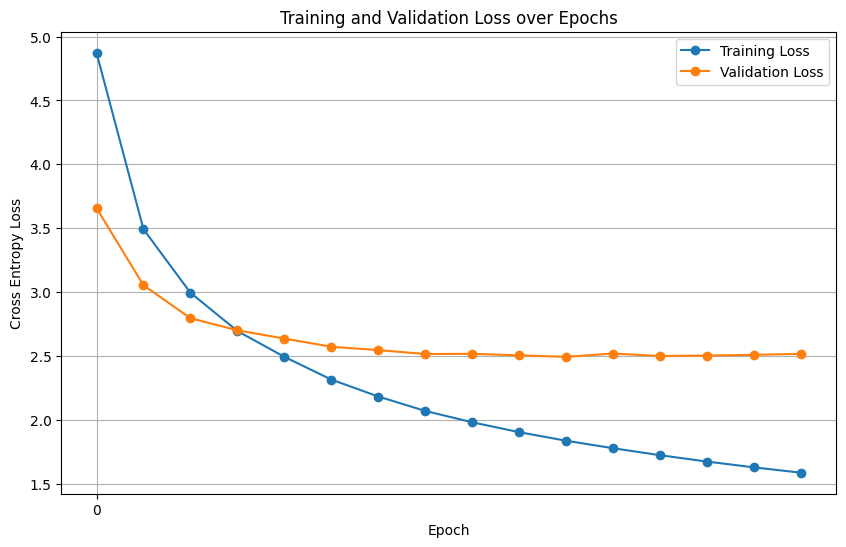

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(train_losses), 18))  # hiển thị mỗi 2 epoch
plt.show()

## 7. Hàm Dịch Một Câu (Translate Sentence)

In [12]:
def translate_sentence(model, src_tensor, src_len, max_len=50):
    model.eval()
    with torch.no_grad():
        # Encoder
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

        # Bắt đầu với token <sos>
        input_token = torch.tensor([TRG_vocab["<sos>"]]).to(model.device)

        translated_tokens = []

        for _ in range(max_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell, encoder_outputs)
            top1 = output.argmax(1)  # chọn token có xác suất cao nhất
            token_id = top1.item()

            if token_id == TRG_vocab["<eos>"]:
                break

            # Chuyển id → token
            token = [k for k, v in TRG_vocab.items() if v == token_id][0]
            translated_tokens.append(token)

            # Cập nhật input cho bước tiếp theo
            input_token = top1

    return translated_tokens


## 8. Tính BLEU Score Trên Test Set

In [13]:
import sacrebleu
from sacrebleu import sentence_bleu  # Thêm import này nếu chưa có

# Dataset cho test
test_dataset = TranslationDataset(test_en, test_fr)

# DataLoader cho test
test_loader = val_loader
# Thu thập hypotheses (giữ nguyên như cũ)
hypotheses = []  # list of str (câu dịch)

# Nhưng cho sentence_bleu, references chỉ cần list of str (mỗi câu 1 reference)
references_single = []  # list of str

attn_model.eval()
with torch.no_grad():
    for src, trg, src_len, trg_len in test_loader:
        src = src.to(device)

        for i in range(src.size(0)):
            src_single = src[i:i+1]               # (1, src_len)
            src_len_single = [src_len[i]]

            hyp_tokens = translate_sentence(attn_model, src_single, src_len_single)
            hypotheses.append(" ".join(hyp_tokens))

            # Reference: chuyển về str (bỏ <sos>, dừng tại <eos>)
            trg_ids = trg[i].tolist()
            eos_idx = trg_ids.index(TRG_vocab["<eos>"]) if TRG_vocab["<eos>"] in trg_ids else len(trg_ids)
            ref_ids = trg_ids[1:eos_idx]  # bỏ <sos>, dừng trước <eos>
            ref_tokens = [list(TRG_vocab.keys())[list(TRG_vocab.values()).index(j)] for j in ref_ids]
            references_single.append(" ".join(ref_tokens))

# Tính BLEU bằng average của sentence_bleu
sentence_scores = []
for hyp, ref in zip(hypotheses, references_single):
    score = sentence_bleu(hyp, [ref])  # sentence_bleu yêu cầu refs là list of str
    sentence_scores.append(score.score)

avg_bleu = sum(sentence_scores) / len(sentence_scores)

print(f"Test BLEU score: {avg_bleu:.2f}")

Test BLEU score: 33.55


## 9. Test Với Các Câu Ví Dụ

In [14]:
# Tạo reverse vocab để ánh xạ id -> token nhanh hơn
id2word_trg = {v: k for k, v in TRG_vocab.items()}

def translate(sentence: str, max_len: int = 50) -> str:
    """
    Dịch một câu tiếng Anh sang tiếng Pháp bằng greedy decoding.
    """
    attn_model.eval()
    with torch.no_grad():
        # 1. Tokenize câu nguồn (EN)
        src_tokens = ["<sos>"] + tokenize_en(sentence) + ["<eos>"]
        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in src_tokens]
        src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)  # (1, src_len)
        src_len = [len(src_ids)]

        # 2. Encode
        encoder_outputs, hidden, cell = attn_model.encoder(src_tensor, src_len)

        # 3. Bắt đầu decode từ <sos>
        input_token = torch.tensor([TRG_vocab["<sos>"]]).to(device)
        translated_tokens = []

        for _ in range(max_len):
            output, hidden, cell = attn_model.decoder(input_token, hidden, cell, encoder_outputs)
            pred_token = output.argmax(1).item()

            if pred_token == TRG_vocab["<eos>"]:
                break

            translated_tokens.append(id2word_trg[pred_token])
            input_token = torch.tensor([pred_token]).to(device)

        return " ".join(translated_tokens)


# Thử dịch một vài câu
example_sentences = [
    "A man is playing a guitar.",
    "Two dogs are running in the park.",
    "A woman is riding a horse.",
    "A group of people are dancing."
]

print("=== Kết quả dịch ===\n")
for en_sent in example_sentences:
    fr_sent = translate(en_sent)
    print(f"EN: {en_sent}")
    print(f"FR: {fr_sent}")
    print("-" * 50)


=== Kết quả dịch ===

EN: A man is playing a guitar.
FR: un homme joue de la guitare .
--------------------------------------------------
EN: Two dogs are running in the park.
FR: deux chiens courent dans le parc .
--------------------------------------------------
EN: A woman is riding a horse.
FR: une femme fait cheval cheval .
--------------------------------------------------
EN: A group of people are dancing.
FR: un groupe de personnes dansent .
--------------------------------------------------
